# Predict Food Demand

## Introduction

Genpact, a food delivery company, is facing financial losses due to understocking key food items, causing customers to leave when products like chicken are unavailable. To address this issue, they have prioritized demand forecasting to accurately predict customer needs and stock the right amount of food. They have hired you, a data scientist, `to analyze their data and provide recommendations on future food demand to ensure proper stocking and cost savings.`

## Aim of Project

The project aims to analyze Genpact's demand dataset and build a complex algorithm to predict future food demand. By the project's end, the algorithm will be deployed as an API using FastAPI, allowing it to be integrated into web or mobile applications for real-world use.

## Source of Project

This project was derived from a [research paper](https://doi.org/10.1109/ACCESS.2023.3266275).

## Dataset description

The ['Food Demand Forecasting' dataset](https://github.com/ikoghoemmanuell/Forecasting_of_Food_Demand_Supply_Chain/tree/main/assets/data) comprises 145 weeks’ worth of weekly orders for 50 distinct meals. The data is spread across 3 files, with about 450,000 entries and 15 features. 

`The task` is to predict demand for the next 10 weeks (Weeks 146–155) using:
- historical demand data (Weeks 1–145)
- meal features (category, sub-category, price, discount)
- fulfillment center details (area, city, etc.).

**1. weekly Demand data (train.csv)**: test.csv doesn't contain the target variable.

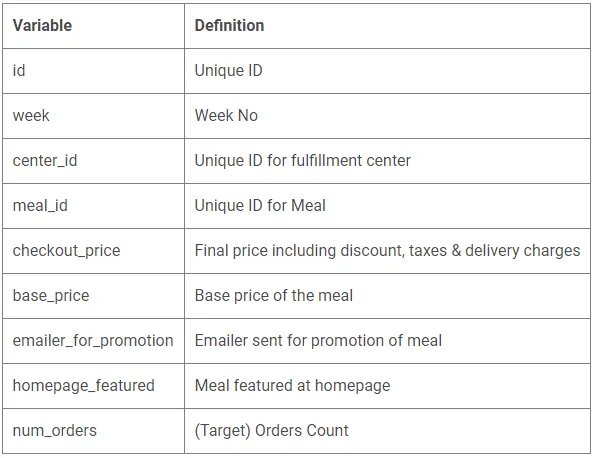

**2. fulfilment_center_info.csv**:

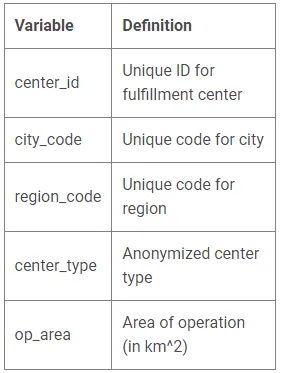

**3. meal_info.csv**:

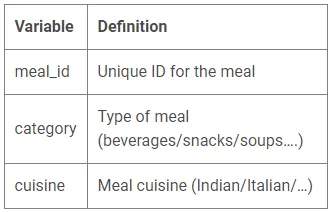

## Libs

In [62]:
import requests
import zipfile
import io
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

In [63]:
url = 'https://github.com/ikoghoemmanuell/Forecasting_of_Food_Demand_Supply_Chain/raw/refs/heads/main/assets/data/Forecasting_of_Food_Demand.zip'
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    ### Download Dataset
    # data_path = './data/'
    # zip_ref.extractall(data_path)
    # train = pd.read_csv(data_path + 'train.csv')
    # test = pd.read_csv(data_path + 'test.csv')
    # sub = pd.read_csv(data_path + 'sample_submission.csv')
    # meals = pd.read_csv(data_path + 'meal_info.csv')
    # centres = pd.read_csv(data_path + 'fulfilment_center_info.csv')

    ### Open the ZIP file in memory
    dfs = []
    # List the files in the ZIP
    file_names = zip_ref.namelist()

    # Assuming there is a CSV file inside the ZIP, extract and read it into a pandas DataFrame
    for file_name in file_names:
        with zip_ref.open(file_name) as csv_file:
            dfs.append(pd.read_csv(csv_file))

In [66]:
centres, meals, sub, test, train = dfs

In [67]:
train.head(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270


In [68]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [69]:
test.head(2)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0


In [70]:
sub.head(2)

,id,num_orders
0,1028232,0
1,1127204,0


In [71]:
meals.head(2)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai


In [72]:
centres.head(2)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7


## EDA

### Univariate Analysis

#### The distribution of features

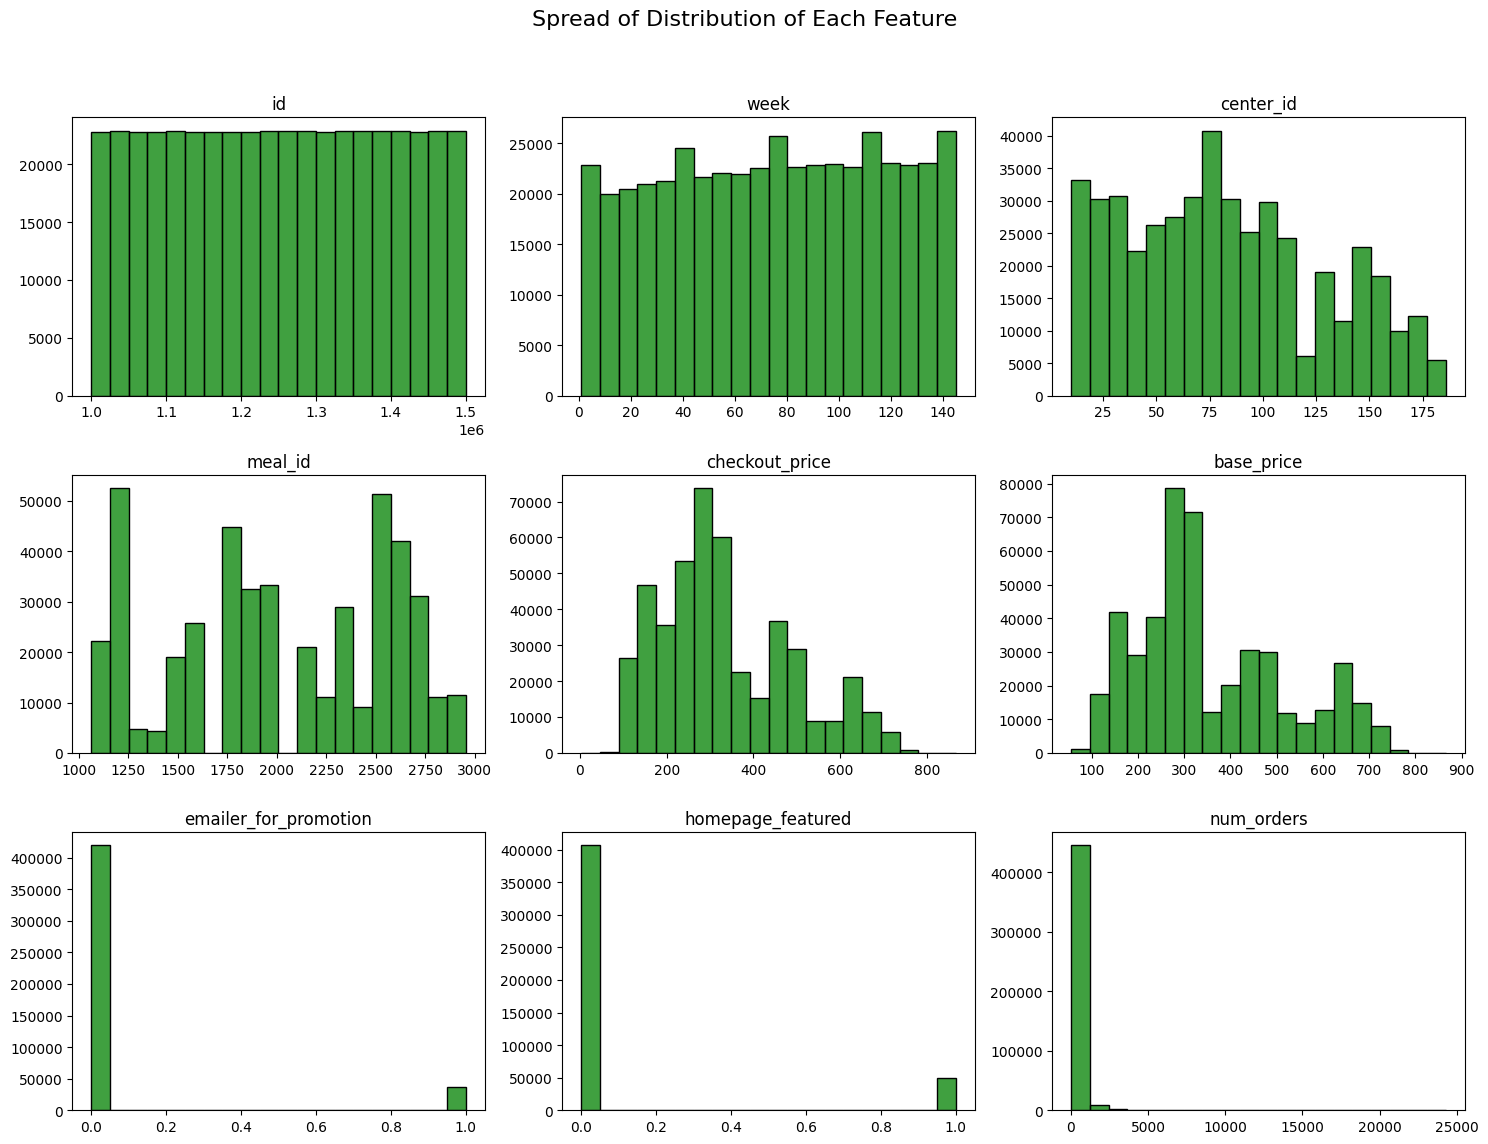

In [10]:
# Generating plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))  # Adjust number of rows and columns as needed
fig.suptitle('Spread of Distribution of Each Feature', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(train.columns):
    if i < len(axes):  # Ensure we don't try to plot more columns than we have axes for
        sns.histplot(train[column], bins=20, kde=False, ax=axes[i], color='green')
        axes[i].set_title(column)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save and show plot
plt.show()

`Note:` the num_orders graph is dramatically skewed left despite of it's NOT a categorical variable => has outliers.

#### Check outliers

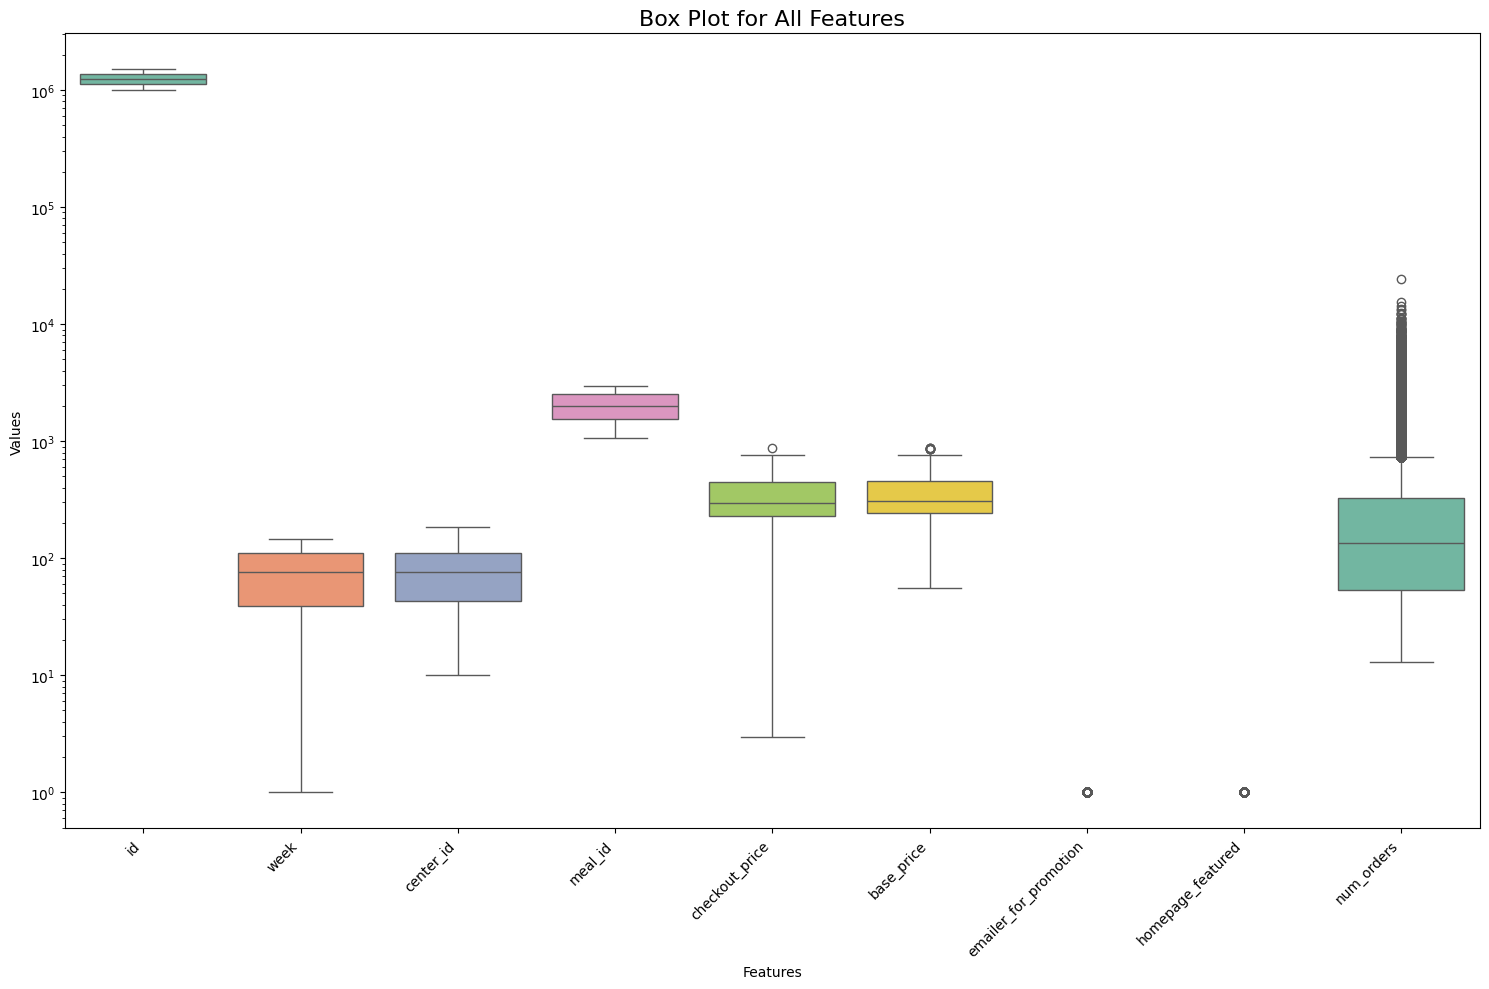

In [11]:
# Creating a boxplot with logarithmic scale for the y-axis
plt.figure(figsize=(15, 10))
ax = sns.boxplot(data=train, palette="Set2")

# Set plot title and labels
plt.title('Box Plot for All Features', fontsize=16)
plt.xlabel('Features')
plt.ylabel('Values')

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save and show plot
plt.show()

Creating a boxplot for the 'num_orders' column

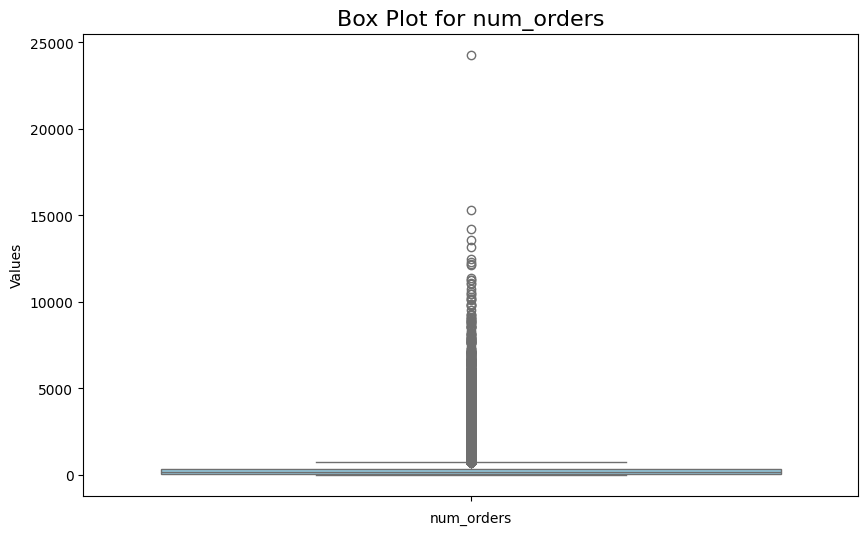

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=train['num_orders'], color='skyblue')

# Set plot title and labels
plt.title('Box Plot for num_orders', fontsize=16)
plt.xlabel('num_orders')
plt.ylabel('Values')

# Show plot
plt.show()

`Note:` num_orders actually have outliers that is greater than 20000.

remove outliers

In [13]:
train = train[train['num_orders'] < 20000]

#### Which type of center received the most orders?

In [14]:
train_centre = pd.merge(train, centres, on='center_id', how='left')
# train_centre

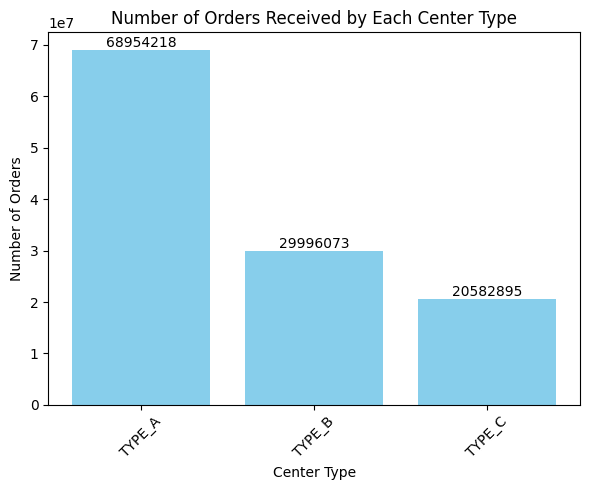

In [15]:
orders_by_center_type = train_centre[['center_type','num_orders']].groupby(['center_type']).sum('num_orders')

# plotting
plt.figure(figsize=(6, 5))
plt.bar(orders_by_center_type.index, orders_by_center_type['num_orders'], color='skyblue')
# Annotate bars with values
for i, value in orders_by_center_type.iterrows():
    plt.text(i, value.values[0] + 0.5, str(value.values[0]), ha='center', va='bottom')

plt.title('Number of Orders Received by Each Center Type')
plt.xlabel('Center Type')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Note:` Type_A has the highest number of orders.

#### What are the top 5 centers?

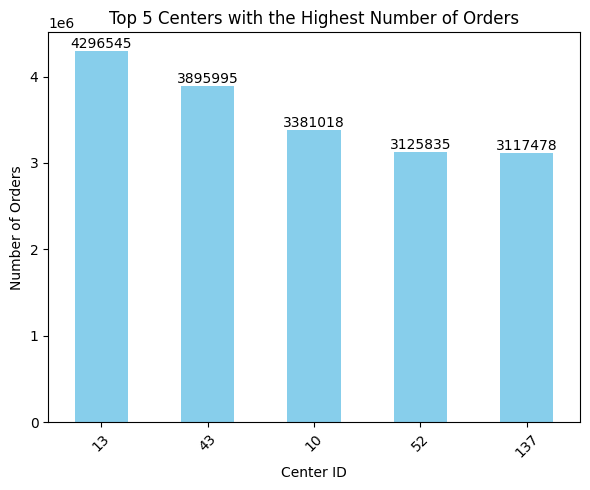

In [16]:
top5_orders_by_center = train.groupby('center_id')['num_orders'].sum().nlargest(5)
# plotting
plt.figure(figsize=(6, 5))
top5_orders_by_center.plot(kind='bar', color='skyblue')
# Annotate bars with values
for i, value in enumerate(top5_orders_by_center):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom')

plt.title('Top 5 Centers with the Highest Number of Orders')
plt.xlabel('Center ID')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Note:` center 13 of Type_B has the highest number of orders although the TYPE_A has the most orders. This is due to Type_A has the most centers.

In [17]:
centres[centres['center_id'].isin(top5_orders_by_center.index)][['center_id','center_type']]

,center_id,center_type
1,13,TYPE_B
36,43,TYPE_A
56,10,TYPE_B
58,52,TYPE_B
62,137,TYPE_A


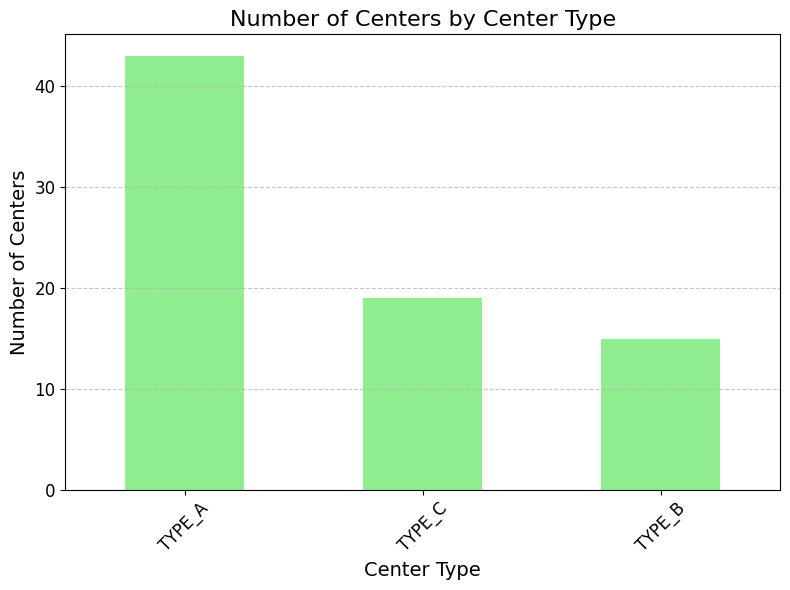

In [18]:
# Count the number of centers under each center type
center_type_counts = centres['center_type'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
center_type_counts.plot(kind='bar', color='lightgreen')
plt.title('Number of Centers by Center Type', fontsize=16)
plt.xlabel('Center Type', fontsize=14)
plt.ylabel('Number of Centers', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### What region has the highest number of orders?

<Figure size 600x500 with 0 Axes>

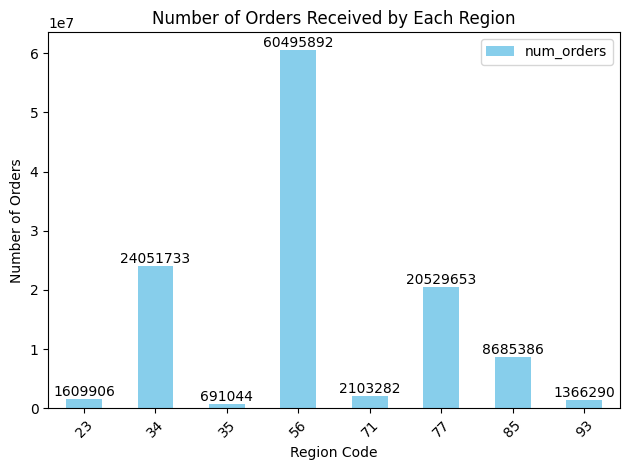

In [19]:
orders_by_center_type = train_centre[['region_code','num_orders']].groupby(['region_code']).sum('num_orders')

# plotting
plt.figure(figsize=(6, 5))
orders_by_center_type.plot(kind='bar', color='skyblue')
# Annotate bars with values
for i, value in enumerate(orders_by_center_type.iterrows()):
    plt.text(i, value[1].iloc[0] + 0.5, str(value[1].iloc[0]), ha='center', va='bottom')

plt.title('Number of Orders Received by Each Region')
plt.xlabel('Region Code')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

`Note:` Region 56 received an astonishingly high number of orders when compared to other regions.

#### Which category of meals have the highest demand?

In [20]:
train_meal = pd.merge(train, meals, on='meal_id', how='left')
# train_meal.head(3)

<Figure size 5000x1000 with 0 Axes>

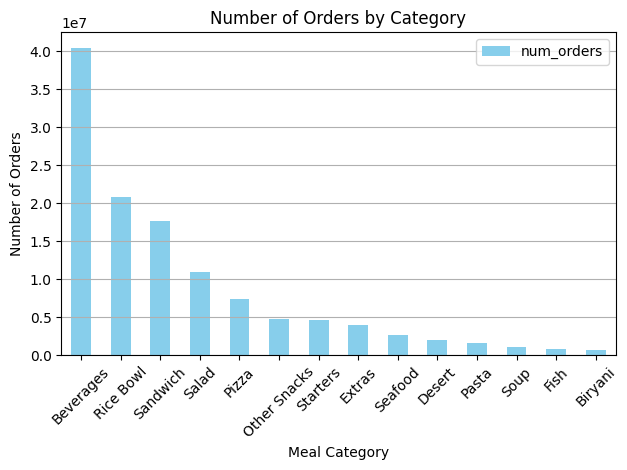

In [21]:
orders_by_meal_type = train_meal[['category','num_orders']].groupby(['category']).sum().sort_values(by='num_orders', ascending=False)
# print(orders_by_meal_type.head(3))
# plotting
plt.figure(figsize=(50, 10))
orders_by_meal_type.plot(kind='bar', color='skyblue')
# Annotate bars with values
# for i, value in enumerate(orders_by_meal_type.iterrows()):
#     plt.text(i, value[1].iloc[0] + 0.5, str(value[1].iloc[0]), ha='center', va='bottom')

plt.title('Number of Orders by Category')
plt.xlabel('Meal Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

`Note:` Beverages are the food category with the highest number of orders (highest demand), and Biryani is the food category with the least number of orders (lowest demand).

#### Which meal was ordered the most?

<Figure size 1200x1000 with 0 Axes>

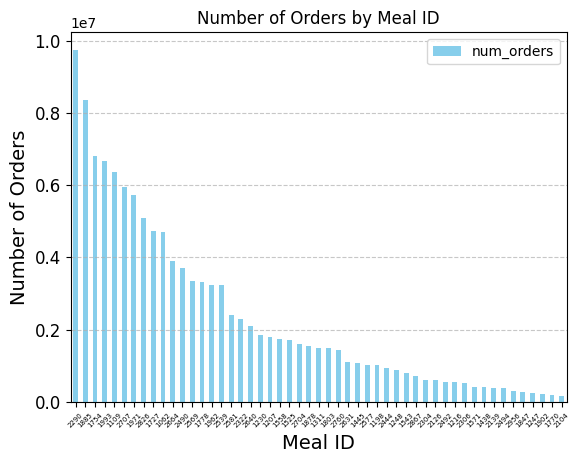

In [22]:
orders_by_meal = train_meal[['meal_id','num_orders']].groupby(['meal_id']).sum().sort_values(by='num_orders', ascending=False)
# print(orders_by_meal_type.head(3))
# plotting
plt.figure(figsize=(12, 10))
orders_by_meal.plot(kind='bar', color='skyblue')
# Annotate bars with values
# for i, value in enumerate(orders_by_meal_type.iterrows()):
#     plt.text(i, value[1].iloc[0] + 0.5, str(value[1].iloc[0]), ha='center', va='bottom')

plt.title('Number of Orders by Meal ID')
plt.xlabel('Meal ID', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45, fontsize=5)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
plt.show()

`Note:` Meal ID 2290 has received the most orders. The number of orders for various meal IDs does not differ significantly in many cases.

#### What are the top 5 cities by demand? (number of orders)

<Figure size 600x500 with 0 Axes>

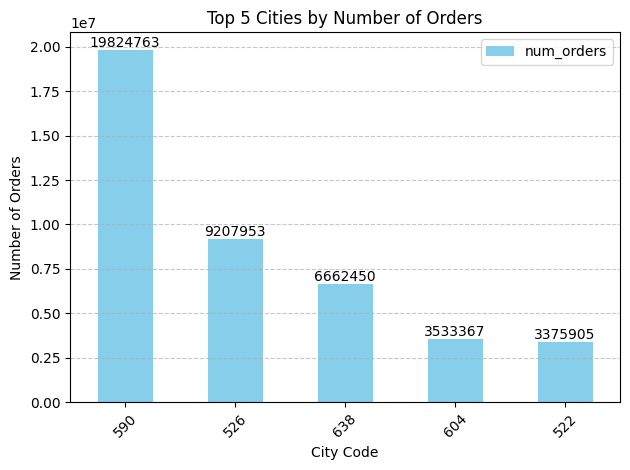

In [23]:
orders_by_cities = train_centre[['city_code','num_orders']].groupby(['city_code']).sum().nlargest(5, 'num_orders')
# print(orders_by_cities)
# plotting
plt.figure(figsize=(6, 5))
orders_by_cities.plot(kind='bar', color='skyblue')
# Annotate bars with values
for i, value in enumerate(orders_by_cities.iterrows()):
    plt.text(i, value[1].iloc[0] + 0.5, str(value[1].iloc[0]), ha='center', va='bottom')

plt.title('Top 5 Cities by Number of Orders')
plt.xlabel('City Code')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

`Note:` City 590 has the most orders with 19.8M, which is 10M more than the city with the second-highest number of orders, City 526, with 9.2M.

#### Which week did we have the lowest demand?

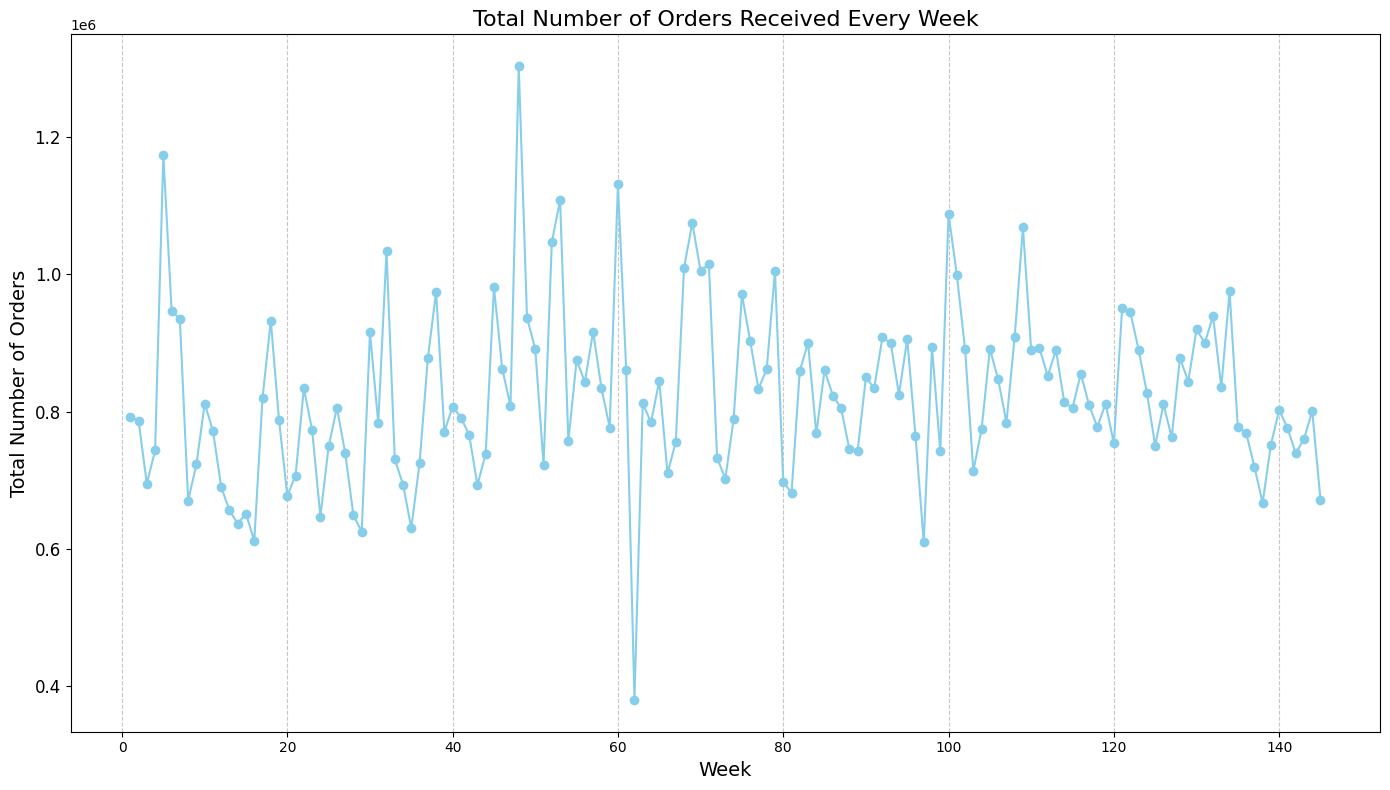

In [24]:
week_order = train.groupby('week')['num_orders'].sum()
# print(week_order)

plt.figure(figsize=(14, 8))
week_order.plot(kind='line', marker='o', color='skyblue')
plt.title('Total Number of Orders Received Every Week', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Number of Orders', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

`Note:` The highest number of orders were received in week 48 and the lowest number of orders in week 62.

### Multivariate Analysis

##### Is there multicollinearity in our variables?

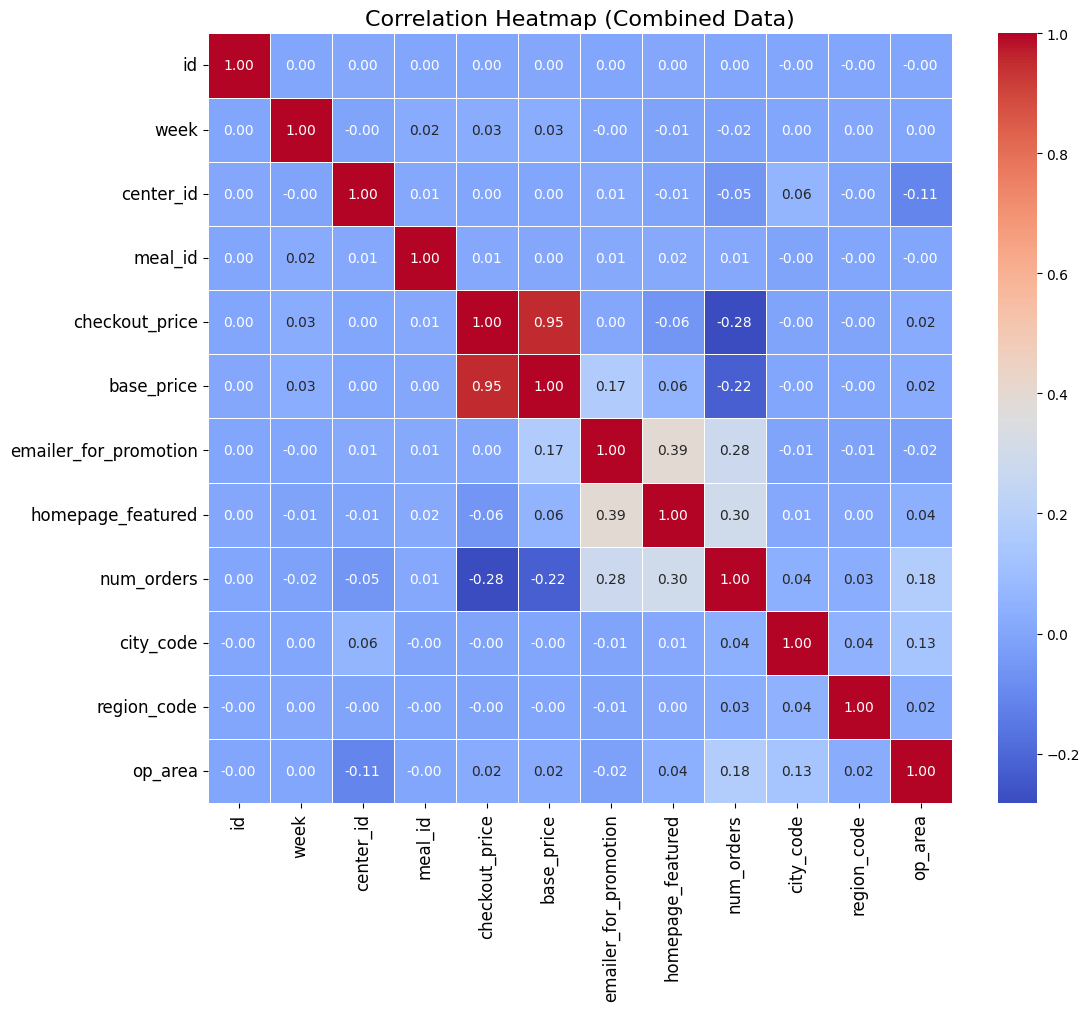

In [25]:
# Select numeric columns from train, centres, and meals DataFrames
train_numeric = train.select_dtypes(exclude=['object'])
centres_numeric = centres.select_dtypes(exclude=['object'])
meals_numeric = meals.select_dtypes(exclude=['object'])

# Merge train, centres, and meals DataFrames
numeric_merged_data = pd.merge(train_numeric, centres_numeric, on='center_id')
numeric_merged_data = pd.merge(numeric_merged_data, meals_numeric, on='meal_id')

corr_matrix = numeric_merged_data.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap (Combined Data)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

`Note:` Base price and checkout price have a high correlation. 

<Figure size 800x600 with 0 Axes>

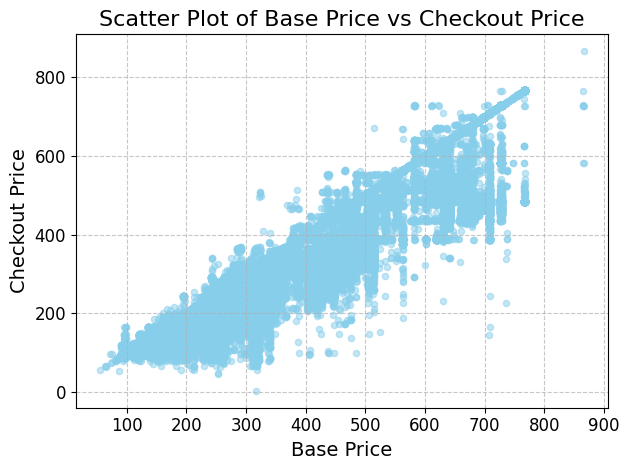

In [26]:
plt.figure(figsize=(8, 6))
train.plot(kind='scatter', x='base_price',y='checkout_price', color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Base Price vs Checkout Price', fontsize=16)
plt.xlabel('Base Price', fontsize=14)
plt.ylabel('Checkout Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

`Note:` base_price and checkout_price actually have a high correlation, so one of variables, checkout_price must be removed.

In [27]:
shorted_train = train.drop(labels='checkout_price', axis=1)
shorted_train.head(3)

,id,week,center_id,meal_id,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,152.29,0,0,177
1,1466964,1,55,1993,135.83,0,0,270
2,1346989,1,55,2539,135.86,0,0,189


### Feature Engineering

#### Create the 'discount' feature

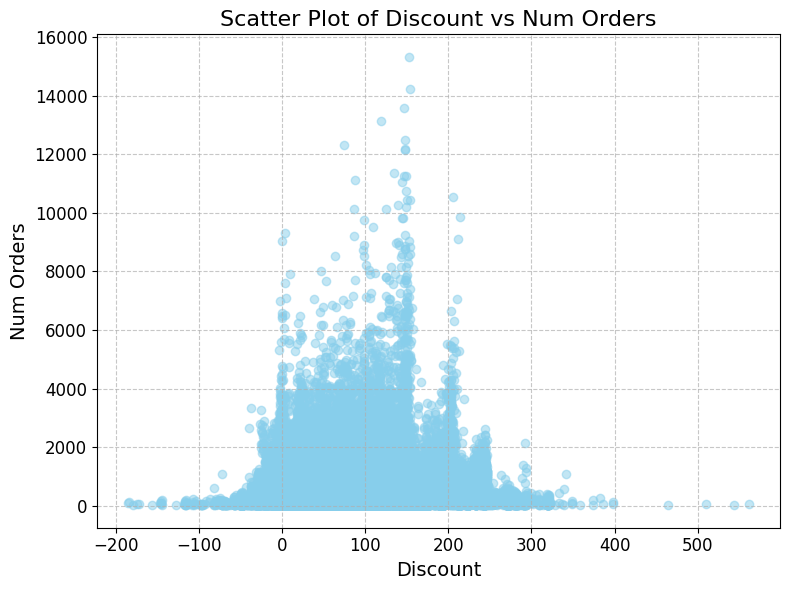

In [28]:
train['discount'] = train['base_price'] - train['checkout_price']

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(train['discount'], train['num_orders'], color='skyblue', alpha=0.5)
plt.title('Scatter Plot of Discount vs Num Orders', fontsize=16)
plt.xlabel('Discount', fontsize=14)
plt.ylabel('Num Orders', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

`Note:` Surprisingly, there is no strong link or correlation between discount and number of orders.

#### Create ewma base price feature and ewma discount feature

In this case, data from the previous 10 weeks is used to forecast demand for the next 10 weeks. So we will set the min_periods as 10 to represent 10 weeks. Now, `the first 9 rows will get NULL value`.

In [29]:
train['ewma_base_price'] = train['base_price'].ewm(alpha=0.5, min_periods=10).mean()
train['ewma_discount'] = train['discount'].ewm(alpha=0.5, min_periods=10).mean()

train[['week', 'base_price', 'discount', 'ewma_base_price', 'ewma_discount']].head(11)

,week,base_price,discount,ewma_base_price,ewma_discount
0,1,152.29,15.46,NaN,NaN
1,1,135.83,-1.00,NaN,NaN
2,1,135.86,1.00,NaN,NaN
3,1,437.53,98.03,NaN,NaN
4,1,242.50,-1.00,NaN,NaN
5,1,252.23,1.00,NaN,NaN
6,1,184.36,1.00,NaN,NaN
7,1,183.36,1.00,NaN,NaN
8,1,192.06,-1.00,NaN,NaN
9,1,384.18,58.26,290.865718,29.895230


#### Handle missing values by interpolation.

In [30]:
train['ewma_base_price'] = train['ewma_base_price'].interpolate(method='linear', limit_direction='backward')
train['ewma_discount'] = train['ewma_discount'].interpolate(method='linear', limit_direction='backward')

train[['week', 'base_price', 'discount', 'ewma_base_price', 'ewma_discount']].head(11)

,week,base_price,discount,ewma_base_price,ewma_discount
0,1,152.29,15.46,290.865718,29.895230
1,1,135.83,-1.00,290.865718,29.895230
2,1,135.86,1.00,290.865718,29.895230
3,1,437.53,98.03,290.865718,29.895230
4,1,242.50,-1.00,290.865718,29.895230
5,1,252.23,1.00,290.865718,29.895230
6,1,184.36,1.00,290.865718,29.895230
7,1,183.36,1.00,290.865718,29.895230
8,1,192.06,-1.00,290.865718,29.895230
9,1,384.18,58.26,290.865718,29.895230


#### Create more features

`Important rule:` New features MUST NOT be created from the target features (number of orders in this case). Because:
- We cannot extract these features from our test set.
- The new ones will have a high correlation with the target and a high feature importance, which is unfair.

In [31]:
merged_data = pd.merge(train, centres, on='center_id')
merged_data = pd.merge(merged_data, meals, on='meal_id')

New features: 
- `meal_base_price_rank`: the rank of a meal based on its base price.
- `meal count` in relation to a meal’s category, cuisine, center, city, and region.
- the `highest, lowest, and average prices of the meal` in a city and a region.
- `base_price_max`: maximum base price for a particular meal, irrespective of the week, center, city, or region.
- `base_price_mean`: the average base price for a particular meal, irrespective of the week, center, city or region.
- `base_price_min`: the minimum base price for a particular meal, irrespective of the week, center, city or region.
- `center_cat_price_rank`: rank of the price of a particular category of meals in a particular center.
- `center_price_rank`: rank of the price of a particular meal in a particular center.
- `center_week_price_rank`: rank of price of a particular meal in a particular center in a particular week.
- `meal_city_price_rank`: rank of price of a particular meal in a particular city.
- `meal_price_max`: maximum checkout price of the meal irrespective of the week,center,city or region.
- `meal_price_mean`: average checkout price of the meal irrespective of the week,center,city or region.
- `meal_price_min`: minimum checkout price of the meal irrespective of the week,center,city or region.
- `meal_price_rank`: rank of price of a particular meal.
- `meal_region_price_rank`: rank of price of a particular meal in a particular region.
- `meal_week_price_rank`: rank of price of a particular meal in a particular week.

In [32]:
# Rank of a meal based on its base price
merged_data['meal_base_price_rank'] = merged_data['base_price'].rank(ascending=False)

# Meal count features
meal_count_features = ['category', 'cuisine', 'center_id', 'city_code', 'region_code']
for feature in meal_count_features:
    merged_data[f'meal_count_{feature}'] = merged_data.groupby(feature)['meal_id'].transform('count')

# Highest, lowest, and average prices of the meal in a city and a region
price_features = ['city_code', 'region_code']
for feature in price_features:
    merged_data[f'{feature}_highest_price'] = merged_data.groupby(feature)['base_price'].transform('max')
    merged_data[f'{feature}_lowest_price'] = merged_data.groupby(feature)['base_price'].transform('min')
    merged_data[f'{feature}_avg_price'] = merged_data.groupby(feature)['base_price'].transform('mean')

# base_price_max, base_price_mean, and base_price_min
merged_data['base_price_max'] = merged_data['base_price'].groupby(merged_data['meal_id']).transform('max')
merged_data['base_price_mean'] = merged_data['base_price'].groupby(merged_data['meal_id']).transform('mean')
merged_data['base_price_min'] = merged_data['base_price'].groupby(merged_data['meal_id']).transform('min')

# center_cat_price_rank
merged_data['center_cat_price_rank'] = merged_data.groupby(['center_id', 'category'])['base_price'].transform('rank')

# center_price_rank
merged_data['center_price_rank'] = merged_data.groupby(['center_id'])['base_price'].transform('rank')

# center_week_price_rank
merged_data['center_week_price_rank'] = merged_data.groupby(['center_id', 'week'])['base_price'].transform('rank')

# meal_city_price_rank
merged_data['meal_city_price_rank'] = merged_data.groupby(['meal_id', 'city_code'])['base_price'].transform('rank')

# meal_price_max, meal_price_mean, and meal_price_min
merged_data['meal_price_max'] = merged_data['base_price'].groupby(merged_data['meal_id']).transform('max')
merged_data['meal_price_mean'] = merged_data['base_price'].groupby(merged_data['meal_id']).transform('mean')
merged_data['meal_price_min'] = merged_data['base_price'].groupby(merged_data['meal_id']).transform('min')

# Compute meal_price_rank
merged_data['meal_price_rank'] = merged_data.groupby(['meal_id'])['base_price'].transform('rank')

# Compute meal_region_price_rank
merged_data['meal_region_price_rank'] = merged_data.groupby(['meal_id', 'region_code'])['base_price'].transform('rank')

# Compute meal_week_price_rank
merged_data['meal_week_price_rank'] = merged_data.groupby(['meal_id', 'week'])['base_price'].transform('rank')

merged_data.head(3)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,discount,...,center_cat_price_rank,center_price_rank,center_week_price_rank,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_price_rank
0,1379560,1,55,1885,136.83,152.29,0,0,177,15.46,...,391.5,396.5,3.0,266.5,179.51,129.510377,88.27,10658.0,3968.5,73.0
1,1466964,1,55,1993,136.83,135.83,0,0,270,-1.00,...,50.5,53.5,1.0,44.0,165.93,129.529039,83.42,6271.5,383.5,60.5
2,1346989,1,55,2539,134.86,135.86,0,0,189,1.00,...,56.5,59.5,2.0,41.0,165.93,130.662846,83.42,5681.5,397.5,68.0


#### Handling Skewness

The values for each feature are not on the same scale, and most of the numerical features in the dataset are heavily right-skewed. Skewness can be decreased by:
- applying the quantile
- power transformation.

In [33]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

# Quantile Transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
train['num_orders_quantile'] = quantile_transformer.fit_transform(train[['num_orders']].values)

# Power Transformation
power_transformer = PowerTransformer()
train['num_orders_power'] = power_transformer.fit_transform(train[['num_orders']].values)

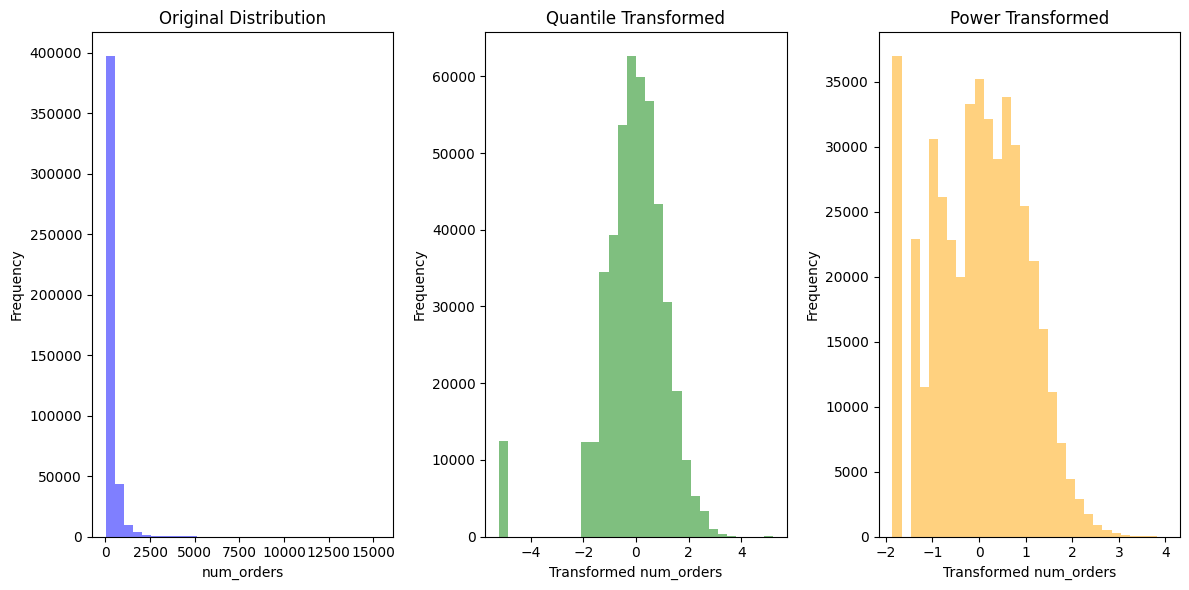

In [34]:
plt.figure(figsize=(12, 6))

# Original Distribution
plt.subplot(1, 3, 1)
plt.hist(train['num_orders'], bins=30, color='blue', alpha=0.5)
plt.title('Original Distribution')
plt.xlabel('num_orders')
plt.ylabel('Frequency')

# Quantile Transformed Distribution
plt.subplot(1, 3, 2)
plt.hist(train['num_orders_quantile'], bins=30, color='green', alpha=0.5)
plt.title('Quantile Transformed')
plt.xlabel('Transformed num_orders')
plt.ylabel('Frequency')

# Power Transformed Distribution
plt.subplot(1, 3, 3)
plt.hist(train['num_orders_power'], bins=30, color='orange', alpha=0.5)
plt.title('Power Transformed')
plt.xlabel('Transformed num_orders')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

`Note:` the quantile transformation reduced skewness more than the power transformation, make the distribution of the data more symmetric and closer to a normal distribution. 

#### Check Normality of All Numerical Columns

In [35]:
categoric_columns = ['center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'city_code', 'region_code', 'center_type', 'op_area', 'category', 'cuisine']
numeric_columns = [col for col in list(merged_data.columns) if col not in categoric_columns + ['id', 'week', 'num_orders']]
print(numeric_columns) # don't scale the target column and timeseries index

['checkout_price', 'base_price', 'discount', 'ewma_base_price', 'ewma_discount', 'meal_base_price_rank', 'meal_count_category', 'meal_count_cuisine', 'meal_count_center_id', 'meal_count_city_code', 'meal_count_region_code', 'city_code_highest_price', 'city_code_lowest_price', 'city_code_avg_price', 'region_code_highest_price', 'region_code_lowest_price', 'region_code_avg_price', 'base_price_max', 'base_price_mean', 'base_price_min', 'center_cat_price_rank', 'center_price_rank', 'center_week_price_rank', 'meal_city_price_rank', 'meal_price_max', 'meal_price_mean', 'meal_price_min', 'meal_price_rank', 'meal_region_price_rank', 'meal_week_price_rank']


H0: non-Gaussian

$p \leq \alpha = 0.05$ => reject H0

In [36]:
from scipy import stats
alpha = 0.05
non_gaussian_cols = [col for col in numeric_columns if stats.normaltest(merged_data[col])[1] < alpha]
print(f'there are {len(non_gaussian_cols)} non-gaussian cols')

there are 30 non-gaussian cols


#### Features Scaling and Encoding

**Encoding categoric columns**

In [37]:
from category_encoders import BinaryEncoder
encoder = BinaryEncoder(drop_invariant=False, return_df=True)
encoded_cat = encoder.fit_transform(merged_data[categoric_columns])
encoded_cat.head(2)

,center_id,meal_id,emailer_for_promotion,homepage_featured,city_code,region_code,center_type_0,center_type_1,op_area,category_0,category_1,category_2,category_3,cuisine_0,cuisine_1,cuisine_2
0,55,1885,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1
1,55,1993,0,0,647,56,0,1,2.0,0,0,0,1,0,0,1


**Scaling numeric columns**

transform with quantile then use the Standard Scaler.

In [38]:
from sklearn.preprocessing import StandardScaler
merged_data[numeric_columns] = quantile_transformer.fit_transform(merged_data[numeric_columns])
scaler = StandardScaler()
scaler.set_output(transform="pandas")
scaler.fit(merged_data[numeric_columns])
merged_data[numeric_columns] = scaler.transform(merged_data[numeric_columns])
merged_data[numeric_columns].head(2)

,checkout_price,base_price,discount,ewma_base_price,ewma_discount,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,meal_count_city_code,...,center_cat_price_rank,center_price_rank,center_week_price_rank,meal_city_price_rank,meal_price_max,meal_price_mean,meal_price_min,meal_price_rank,meal_region_price_rank,meal_week_price_rank
0,-1.533799,-1.381915,0.673480,-0.523338,0.696649,1.406947,1.51728,0.015869,-1.105059,-0.04936,...,0.669901,-1.495600,-1.216391,0.886757,-0.916694,-3.744483,-0.852497,2.149988,2.175373,1.887212
1,-1.533799,-1.768484,-0.984992,-0.523338,0.696649,1.761352,1.51728,0.015869,-1.105059,-0.04936,...,-1.232560,-2.378171,-4.239095,-0.723739,-3.236903,-1.289033,-1.083568,0.413842,-0.808232,0.974540


In [39]:
merged_data = pd.concat([merged_data['week'], merged_data[numeric_columns], encoded_cat, merged_data.num_orders], axis=1)
merged_data.head(2)

,week,checkout_price,base_price,discount,ewma_base_price,ewma_discount,meal_base_price_rank,meal_count_category,meal_count_cuisine,meal_count_center_id,...,center_type_1,op_area,category_0,category_1,category_2,category_3,cuisine_0,cuisine_1,cuisine_2,num_orders
0,1,-1.533799,-1.381915,0.673480,-0.523338,0.696649,1.406947,1.51728,0.015869,-1.105059,...,1,2.0,0,0,0,1,0,0,1,177
1,1,-1.533799,-1.768484,-0.984992,-0.523338,0.696649,1.761352,1.51728,0.015869,-1.105059,...,1,2.0,0,0,0,1,0,0,1,270


In [40]:
import pickle

with open('./models/encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

with open('./models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

## ML Models for Forecasting

### Splitting Dataset

Split the dataset into sets:
- training (weeks 1-135)
- evaluation (weeks 136-145)

In [41]:
train = merged_data[merged_data['week'] <= 135]
eval = merged_data[merged_data['week'] > 135]

print("Training set shape:", train.shape)
print("Evaluation set shape:", eval.shape)

X_train = train.drop(['num_orders'], axis = 1)
X_val = eval.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
y_val = eval['num_orders']

Training set shape: (423726, 48)
Evaluation set shape: (32821, 48)


### Random Forest

#### Theory

**Step 1: Create Diverse Decision Trees**

- Randomly pick data points from the original dataset to create multiple training sets (bagging step).
- Each decision tree selects a subset of features for training based on which features reduce the data’s variance.

**Step 2: Combine Results for Prediction**

- For classification, the final prediction is the most frequent class chosen by the trees.
- For regression, the final prediction is the average of all the trees’ predictions.

**Advantages of Random Forests**

- Handles both numerical and categorical features well.
- Works well with datasets having many features.

**Disadvantages of Random Forests**

- Poor at predicting values outside the training data’s range makes them unsuitable for time series forecasting like.
- Slow and ineffective for real time predictions as it may not be able to identify and formulate an increasing or decreasing trend.

#### Implement

In [47]:
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor().fit(X_train, y_train)
y_pred = forest_model.predict(X_val)

In [45]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
res = pd.DataFrame(columns=['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])

def evaluation(model_name, y_val, y_pred):
    mse = mean_squared_error(y_val, y_pred)
    msle = mean_squared_log_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(msle)

    new_res = pd.DataFrame([[model_name, mse, msle, rmse, rmsle]], columns=res.columns)
    return pd.concat([res, new_res], ignore_index=True)

res = evaluation('Random Forest', y_val, y_pred)
res

#### Saving Model

In [86]:
# with open("./models/forest_model.pkl", "wb") as f:
#     pickle.dump(forest_model, f)

#### Hyperparameter Tunning

In [ ]:
# param_grid = {
#     'max_depth': [8, 9, 10],
#     'max_features': ['sqrt'],
#     'n_estimators': [100, 150, 200],
#     'min_samples_leaf': [2, 3, 4]
# }

# # Initialize the Random Forest Regressor
# forest = RandomForestRegressor()

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='neg_mean_squared_log_error', cv=5)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best parameters and best RMSLE score
# best_params = grid_search.best_params_
# best_rmsle = np.sqrt(-grid_search.best_score_)

# # Print the best parameters and best RMSLE score
# print("Best Parameters:", best_params)
# print("Best RMSLE Score:", best_rmsle)

### Gradient Boosting Machine (GBM)

#### Theory

Gradient boosting is just like the random forest with a “boost”. Each new decision tree improves on the errors made by the previous decision tree, increasing accuracy using gradient descent. Here are the steps:

**Step 1: Start Simple**

- The first decision tree makes a constant prediction.

**Step 2: Iterate**

- Calculate the errors made by the last tree.
- Make predictions to correct these errors.
- Add the new predictions to the previous ones.

**Step 3: Combine**

- Finally, combine all the small decision trees to get the final improved prediction.

**Challenges**

- Training trees one by one can be time-consuming, especially for massive datasets. 
- Strain computational resources due to storing and manipulating intermediate results (errors) from previous trees.

#### Implement

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor().fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_val)

In [67]:
gbr_pred = np.abs(gbr_pred)

In [70]:
res = evaluation('Gradient Boosting', y_val, gbr_pred)
res 

,Model,MSE,MSLE,RMSE,RMSLE
0,NaN,NaN,NaN,NaN,NaN
1,Random Forest,16594.457838,0.294143,128.819478,0.542350
2,Gradient Boosting,22469.532059,0.565209,149.898406,0.751804


#### Saving Model

In [87]:
# with open("./models/gbr_model.pkl", "wb") as f:
#     pickle.dump(gbr_model, f)

### Light GBM

#### Theory

Light GBM is an optimized version of the GBM. Light GBM uses a leaf-wise policy, which helps minimize losses by splitting the tree along the best nodes.

**Advantages:**
- can handle missing data
- support parallelism
- its distributed computing approach

**Disadvantage:** very sensitive to outliers.

#### Implement

In [ ]:
# !pip install lightgbm

In [ ]:
# from lightgbm import LGBMRegressor
# lgbm_model = LGBMRegressor().fit(X_train, y_train)
# lgbm_pred = np.abs(lgbm_model.predict(X_val))

In [ ]:
# res = evaluation('LightGBM', y_val, gbr_pred)
# res

### XGBoost

#### Theory

XGBoost algorithms tackle challenges of GBM by:

- `Parallelization and Distributed Computing`: splits the training data across multiple cores or machines => allow simultaneous training of multiple trees => significantly speeding up the process.
- `Gradient Sampling`: Instead of using errors from all data points for each tree, XGBoost can utilize a smaller, randomly chosen sample of the data. This reduces computation and memory usage without significantly impacting accuracy.

**Disadvantage:** very sensitive to outliers.

#### Implement

In [73]:
from xgboost import XGBRegressor
xgboost_model = XGBRegressor().fit(X_train, y_train)
xgboost_pred = np.abs(xgboost_model.predict(X_val))

In [74]:
res = evaluation('XGBoost', y_val, y_pred)
res 

,Model,MSE,MSLE,RMSE,RMSLE
0,NaN,NaN,NaN,NaN,NaN
1,Random Forest,16594.457838,0.294143,128.819478,0.542350
2,Gradient Boosting,22469.532059,0.565209,149.898406,0.751804
3,LightGBM,22469.532059,0.565209,149.898406,0.751804
4,XGBoost,16594.457838,0.294143,128.819478,0.542350


#### Saving Model

In [88]:
# with open("./models/xgboost_model.pkl", "wb") as f:
#     pickle.dump(xgboost_model, f)

### CatBoost

#### Theory

- employs GBM on decision trees, using balanced trees for more efficient parameter tuning. 
- builds an oblivious tree model on randomly shuffled training data to enhance robustness and prevent overfitting.
- efficient in memory usage, operates quickly, and delivers accurate results.
- performs best on datasets with many categorical features. 
- may be slower on datasets with few categorical features.

#### Implement

In [ ]:
# !pip install catboost

In [ ]:
# from catboost import CatBoostRegressor
# catboost_model = CatBoostRegressor(silent=True).fit(X_train, y_train)
# catboost_pred = np.abs(catboost_model.predict(X_val))

In [ ]:
# res = evaluation('CatBoost', y_val, y_pred)
# res

### LSTM

#### Theory

This summary provides an overview of Long Short-Term Memory (LSTM) networks, a variation of Recurrent Neural Networks (RNNs) designed to handle long-term dependencies. The explanation avoids complex math, focusing instead on the four key structural components of LSTMs: the input gate, output gate, forget gate, and cell state.

- **Cell State**: Stores information at time `t` to ensure data continuity.
- **Forget Gate**: Decides what information should be retained or discarded, helping the network focus on relevant data for future predictions.

The model's architecture consists of 10 timesteps and 13 features per input sample (representing 10 weeks and 13 features per week). The model uses three LSTM layers, each paired with a ReLU and dropout layer to prevent overfitting.

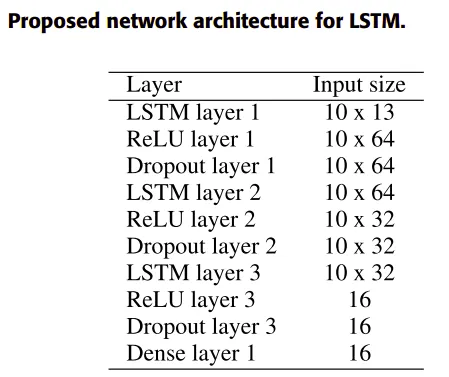

In our scenario, e.g., at timestep 20, the model should only be trained on data spanning from 13 to 20 and should not be exposed to data spanning from 21 to 125.

#### Implement

In [44]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, ReLU, Bidirectional
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

**Create sequences for LSTM input**

In [51]:
def create_sequences(X: pd.DataFrame, y: pd.Series, time_steps=10):
    X_values = X.values
    y_values = y.values
    
    Xs = np.array([X_values[i:i + time_steps] for i in range(len(X_values) - time_steps)])
    ys = np.array([y_values[i + time_steps] for i in range(len(y_values) - time_steps)])
    
    return Xs, ys

time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, time_steps)

# Reshape y_train_seq and y_test_seq to be 2D arrays
y_train_seq = y_train_seq.reshape(-1, 1)
y_val_seq = y_val_seq.reshape(-1, 1)

# Check the shapes
print(X_train_seq.shape, y_train_seq.shape)
print(X_val_seq.shape, y_val_seq.shape)

(423716, 10, 47) (423716, 1)
(32811, 10, 47) (32811, 1)


**Define LSTM Model**

In [48]:
class LSTMs(keras.Model):
    def __init__(self, input_shape):
        super(LSTMs, self).__init__()
        # layer 1
        self.lstm = LSTM(64, input_shape=input_shape, return_sequences=True)
        self.relu = ReLU()
        self.drop_out = Dropout(0.25)

        # layer 2
        self.lstm2 = LSTM(32, return_sequences=True)
        self.relu2 = ReLU()
        self.drop_out2 = Dropout(0.25)

        # layer 3
        self.lstm3 = LSTM(16)
        self.relu3 = ReLU()
        self.drop_out3 = Dropout(0.25)

        # dense layer
        self.dense = Dense(1)

    def call(self, inputs):
        x = self.drop_out(self.relu(self.lstm(inputs)))
        x = self.drop_out2(self.relu2(self.lstm2(x)))
        x = self.drop_out3(self.relu3(self.lstm3(x)))
        return self.dense(x)
    
input_shape = (time_steps, X_train_seq.shape[2])
lstm = LSTMs(input_shape)
lstm.compile(optimizer=Adam(), loss='mean_squared_error')

lstm.summary()

Model: "lst_ms"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Training**

In [49]:
history = lstm.fit(X_train_seq, y_train_seq, epochs=1, batch_size=16, validation_data=(X_val_seq, y_val_seq))

26483/26483 ━━━━━━━━━━━━━━━━━━━━ 271s 10ms/step - loss: 210247.4844 - val_loss: 81307.2500


**Evaluation**

In [57]:
lstm_pred = lstm.predict(X_val_seq)

# Clip negative values to 0
lstm_pred = np.clip(lstm_pred, 0, None)

res = evaluation('LSTM', y_val_seq, lstm_pred)
res

1026/1026 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


,Model,MSE,MSLE,RMSE,RMSLE
0,NaN,NaN,NaN,NaN,NaN
1,LSTM,81307.26263,1.37888,285.144284,1.174257


#### Saving Model

### Bi-LSTM

#### Theory

Architecture:

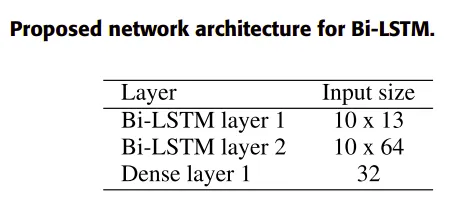

#### Implement

**Define Bi-LSTM Model**

In [53]:
class Bi_LSTMs(keras.Model):
    def __init__(self, input_shape):
        super(Bi_LSTMs, self).__init__()
        # Bi-LSTM layer 1
        self.bilstm = Bidirectional(LSTM(32, return_sequences=True, dropout=0.25, recurrent_activation='tanh'), input_shape=input_shape)

        # Bi-LSTM layer 2
        self.bilstm2 = Bidirectional(LSTM(16, return_sequences=False, dropout=0.25, recurrent_activation='tanh'))

        # Dense layer
        self.dense = Dense(1)

    def call(self, inputs):
        x = self.bilstm(inputs)
        x = self.bilstm2(x)
        return self.dense(x)
    
input_shape = (time_steps, X_train_seq.shape[2])
bilstm = Bi_LSTMs(input_shape)
bilstm.compile(optimizer=Adam(), loss='mean_squared_error')

bilstm.summary()

Model: "bi_lst_ms"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Training**

In [54]:
history = bilstm.fit(X_train_seq, y_train_seq, epochs=1, batch_size=16, validation_data=(X_val_seq, y_val_seq))

26483/26483 ━━━━━━━━━━━━━━━━━━━━ 240s 9ms/step - loss: 183169.2344 - val_loss: 77754.4375


**Evaluation**

In [58]:
bilstm_pred = bilstm.predict(X_val_seq)

# Clip negative values to 0
bilstm_pred = np.clip(bilstm_pred, 0, None)

res = evaluation('Bi-LSTM', y_val_seq, lstm_pred)
res

1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


,Model,MSE,MSLE,RMSE,RMSLE
0,NaN,NaN,NaN,NaN,NaN
1,LSTM,81307.26263,1.37888,285.144284,1.174257
2,Bi-LSTM,81307.26263,1.37888,285.144284,1.174257


#### Saving Model

### Results

In [59]:
res

,Model,MSE,MSLE,RMSE,RMSLE
1,LSTM,81307.26263,1.37888,285.144284,1.174257
2,Bi-LSTM,81307.26263,1.37888,285.144284,1.174257


## API deployment

In [61]:
!py main.py

INFO:     Will watch for changes in these directories: ['c:\\Users\\dangc\\Downloads\\ongoing pj\\timeseries']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [14676] using StatReload
INFO:     Stopping reloader process [14676]


# Inference

[Regression Project — Predict Food Demand (Part 1)](https://medium.com/thedeephub/regression-predict-food-demand-part-1-ec86e29f7a63)

[Regression Project — Predict Food Demand (Part 2)](https://medium.com/thedeephub/predict-food-demand-with-python-part-2-2ede9b36e9d0)